<a href="https://colab.research.google.com/github/washmore1/IS4100FinalProject/blob/main/FinalAnalysis_WA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nfl_data_py
import numpy as np
import pandas as pd
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm
from scipy.stats import poisson
import os.path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq, kmeans

##**Past Analysis**
The Miami Dolphins and the San Francisco 49ers in particular are known for creative, balanced, and explosive offenses. I think that assertion is supported by the research in this assignment:
  - Miami Dolphins offensive rankings (among my 8 teams)
    - Passing: #1
    - Rushing: #3
  - San Francisco 49ers offensive rankings (among my 8 teams)
    - Passing: #2
    - Rushing: #2

In addition, I believe this research aligns with the common thought that QB play is the strongest indicator of a team's success. I have previously pointed out with the Houston Texans struggles in 2022 with Davis Mills at QB versus their success in 2023 with rising star C.J. Stroud at the helm, but this isn't the only example in my 8-team scope. In the opposite direction, the Washington Commanders win total decreased 4 games from somewhat-competitive 8-9 record in 2022, to an abysmal 4-13 record in 2023. This correlates with the Commanders' change from the servicable Taylor Heinicke to a young, inexperienced QB in Sam Howell.

In [ ]:
df = nfl.import_schedules([2022])
def calculate_win_loss(team, df):

    team_df = df[(df['home_team'] == team) | (df['away_team'] == team)]

    wins = 0
    losses = 0

    for _, row in team_df.iterrows():
        if (row['home_team'] == team and row['home_score'] > row['away_score']) or \
           (row['away_team'] == team and row['away_score'] > row['home_score']):
            wins += 1
        else:
            losses += 1

    return wins, losses


# List of teams
teams = ['MIA', 'PIT', 'HOU', 'DEN', 'WAS', 'CHI', 'TB', 'SF']

# Calculate and display the win-loss record for each team
for team in teams:
    wins, losses = calculate_win_loss(team, df)
    print(f"\n{team} 2022 Record: {wins} Wins, {losses} Losses")


MIA 2022 Record: 9 Wins, 9 Losses

PIT 2022 Record: 9 Wins, 8 Losses

HOU 2022 Record: 3 Wins, 14 Losses

DEN 2022 Record: 5 Wins, 12 Losses

WAS 2022 Record: 8 Wins, 9 Losses

CHI 2022 Record: 3 Wins, 14 Losses

TB 2022 Record: 8 Wins, 10 Losses

SF 2022 Record: 15 Wins, 5 Losses


In [ ]:
df = nfl.import_schedules([2023])
def calculate_win_loss(team, df):

    team_df = df[(df['home_team'] == team) | (df['away_team'] == team)]

    wins = 0
    losses = 0

    for _, row in team_df.iterrows():
        if (row['home_team'] == team and row['home_score'] > row['away_score']) or \
           (row['away_team'] == team and row['away_score'] > row['home_score']):
            wins += 1
        else:
            losses += 1

    return wins, losses


# List of teams
teams = ['MIA', 'PIT', 'HOU', 'DEN', 'WAS', 'CHI', 'TB', 'SF']

# Calculate and display the win-loss record for each team
for team in teams:
    wins, losses = calculate_win_loss(team, df)
    print(f"\n{team} 2023 Record: {wins} Wins, {losses} Losses")


MIA 2023 Record: 11 Wins, 7 Losses

PIT 2023 Record: 10 Wins, 8 Losses

HOU 2023 Record: 11 Wins, 8 Losses

DEN 2023 Record: 8 Wins, 9 Losses

WAS 2023 Record: 4 Wins, 13 Losses

CHI 2023 Record: 7 Wins, 10 Losses

TB 2023 Record: 10 Wins, 9 Losses

SF 2023 Record: 14 Wins, 6 Losses


##**SLR**

- The 49ers-Rams game is a major outlier in my model, as QB Brock Purdy recorded a 137.1 passer rating, yet SF still lost. That QB performance results in a win 92% of the time!
- Passer Rating is a strong indicator of how a game will result, but is not an end-all-be-all.
- While more difficult, it would be more valuable to project a player's passer rating output using factors that include the strength of the other team's defense.

2023 done.
Downcasting floats.


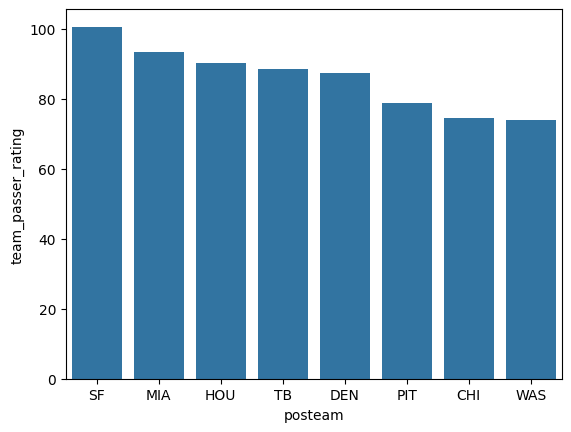

In [ ]:
teams = ['MIA', 'PIT', 'HOU', 'DEN', 'WAS', 'CHI', 'TB', 'SF']

pbp_2023 = nfl.import_pbp_data([2023])

team_passing_data = pbp_2023[(pbp_2023['posteam'].isin(teams)) & (pbp_2023['pass_attempt'] == 1)].copy()

team_passing_stats = team_passing_data.groupby('posteam').agg(
    completions=('complete_pass', 'sum'),
    attempts=('pass_attempt', 'count'),
    passing_yards=('passing_yards', 'sum'),
    touchdowns=('pass_touchdown', 'sum'),
    interceptions=('interception', 'sum')
).reset_index()

# passer_rating_function
def passer_rating_function(row):
    a = ((row['completions'] / row['attempts']) - 0.3) * 5
    b = ((row['passing_yards'] / row['attempts']) - 3) * 0.25
    c = (row['touchdowns'] / row['attempts']) * 20
    d = 2.375 - (row['interceptions'] / row['attempts']) * 25

    a = max(0, min(a, 2.375))
    b = max(0, min(b, 2.375))
    c = max(0, min(c, 2.375))
    d = max(0, min(d, 2.375))

    passer_rating = ((a + b + c + d) / 6) * 100
    return passer_rating

team_passing_stats['team_passer_rating'] = team_passing_stats.apply(passer_rating_function, axis=1)

team_passing_stats = team_passing_stats.sort_values(by='team_passer_rating', ascending=False)

sns.barplot(data = team_passing_stats,
                x = 'posteam',
                y = 'team_passer_rating')

plt.show()

In [ ]:
seasons = seasons = range(2016,2024 +1)
data = nfl.import_pbp_data(seasons)

qb_data = data[data['pass_attempt'] == 1].copy()

qb_pass_attempts = qb_data.groupby(['passer_player_name', 'game_id']).agg(
    pass_attempts=('pass_attempt', 'count')
).reset_index()

games = qb_pass_attempts[qb_pass_attempts['pass_attempts'] > 12]

qb_data = qb_data.merge(games[['passer_player_name', 'game_id']],
                          on=['passer_player_name', 'game_id'],
                          how='inner')

def game_result(row):
    if row['posteam'] == row['home_team']:
        return 1 if row['home_score'] > row['away_score'] else 0
    else:
        return 1 if row['away_score'] > row['home_score'] else 0

qb_data['team_won'] = qb_data.apply(game_result, axis=1)

qb_stats = qb_data.groupby(['passer_player_name', 'game_id', 'team_won']).agg(
    completions=('complete_pass', 'sum'),
    attempts=('pass_attempt', 'count'),
    passing_yards=('passing_yards', 'sum'),
    touchdowns=('pass_touchdown', 'sum'),
    interceptions=('interception', 'sum')
).reset_index()

qb_stats['passer_rating'] = qb_stats.apply(passer_rating_function, axis=1)

qb_stats = qb_stats.sort_values(by=['passer_player_name', 'game_id'])

qb_pr_avg = qb_stats.groupby(
    ['team_won']
).agg(
    {
        'passer_rating': ['mean']
    }
)

qb_pr_avg.columns = list(
    map(
        "_".join, qb_pr_avg.columns
    )
)

qb_pr_avg.reset_index(inplace=True)

# Linear Regression Results
pr_winning = smf.ols(
    formula = 'passer_rating ~ team_won',
    data = qb_stats
)

print(pr_winning.fit().summary())

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
                            OLS Regression Results                            
Dep. Variable:          passer_rating   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1450.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):          2.85e-278
Time:                        02:48:31   Log-Likelihood:                -22328.
No. Observations:                4908   AIC:                         4.466e+04
Df Residuals:                    4906   BIC:                         4.467e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

Accuracy: 0.70
Confusion Matrix:
[[364 129]
 [167 322]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       493
           1       0.71      0.66      0.69       489

    accuracy                           0.70       982
   macro avg       0.70      0.70      0.70       982
weighted avg       0.70      0.70      0.70       982



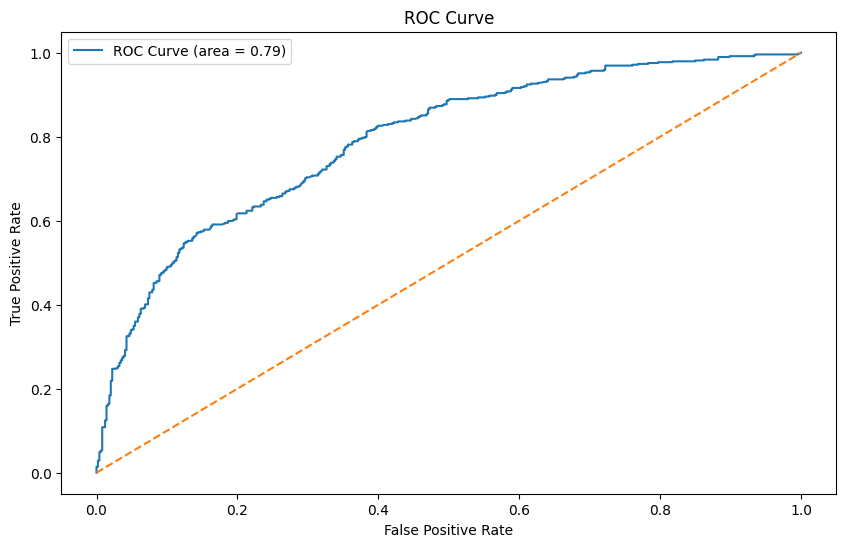

In [ ]:
qb_stats.dropna(inplace=True)

X = qb_stats[['passer_rating']]
y = qb_stats['team_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

##**MLR**

**Model Factors**
1. Passing Yards
2. Rushing Yards
3. Plays
4. Turnovers (INT + Fumbles)
5. Sacks Allowed

- My MLR model using the features that I chose is far from a reliable predictor for forecasting points scored, but it did perform slightly better than the simple linear regression model which I'll take as a win

- It was interesting to see that, while splitting hairs, the model does assess a rushing yard as being a more positive impact than a passing yard

- I found that the correlation between giving up a sack and it hurting the expected point total was greater than I anticipated

- Lastly, I found it interesting (and it makes sense) how the model assessed that running more plays in a game has a negative impact on ultimately scoring points

  - a quick, explosive offense is more likely to put up more points than a slow, grind-it-out, wear you down offense.
  - That's not to say that a quick and explosive offense is better; there are undoubtedly side effects to an explosive offense felt by the defensive side

In [ ]:
# Load play-by-play data
seasons = range(2016,2024,+1)

pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [ ]:
all_valid_pbp = pbp[
    (
        (pbp['play_type'] == 'run') &
        (pbp['rusher_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['run_location'].notnull())
    )
    |
    (
        (pbp['play_type'] == 'pass') &
        (pbp['passer_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['pass_location'].notnull())
    )
]

# Grabs the last row of a game, which contains the final score
final_scores = all_valid_pbp.drop_duplicates(subset=['game_id', 'posteam'], keep='last')

# Gets the final points scored for each team in each game
team_points_scored = final_scores.groupby(['posteam', 'game_id']).agg(
    points_scored = pd.NamedAgg(column='posteam_score', aggfunc='last')
).reset_index()

# Valid Passes only
valid_pass_pbp = pbp[
    (
        (pbp['play_type'] == 'pass') &
        (pbp['passer_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['pass_location'].notnull())
    )
]

# Finds the total passing yards for each posteam in each game
team_passing_yards = valid_pass_pbp.groupby(['posteam', 'game_id']).agg(
    total_passing_yards = pd.NamedAgg(column='yards_gained', aggfunc='sum')
).reset_index()

# only valid run plays
valid_rush_pbp = pbp[
    (
        (pbp['play_type'] == 'run') &
        (pbp['rusher_id'].notnull()) &
        (pbp['down'].notnull()) &
        (pbp['run_location'].notnull())
    )
]

# finds the total rushing yards for each posteam in each game
team_rushing_yards = valid_rush_pbp.groupby(['posteam', 'game_id']).agg(
    total_rushing_yards = pd.NamedAgg(column='yards_gained', aggfunc='sum')
).reset_index()

# finds the total offensive plays ran by each posteam in each game
team_total_plays = all_valid_pbp.groupby(['posteam', 'game_id']).agg(
    total_plays = pd.NamedAgg(column='play_id', aggfunc='count')
).reset_index()

# only plays with a turnover (INT or a fumble lost)
turnovers_pbp = pbp[(pbp['interception'] == 1)
|
(pbp['fumble_lost'] == 1)]

# finds the number of INT's thrown & fumbles lost by a posteam in each game
team_turnovers = turnovers_pbp.groupby(['posteam', 'game_id']).agg(
    interceptions = pd.NamedAgg(column='interception', aggfunc='sum'),
    fumbles_lost = pd.NamedAgg(column='fumble_lost', aggfunc='sum')
).reset_index()

# Sums together INT's & Fumbles to populate the total_turnovers column
team_turnovers['total_turnovers'] = team_turnovers['interceptions'] + team_turnovers['fumbles_lost']

# only plays with a sack
sacks_pbp = pbp[pbp['sack'] == 1]

# finds the number of sacks given up by a posteam in each game
team_sacks_allowed = sacks_pbp.groupby(['posteam', 'game_id']).agg(
    sacks_allowed = pd.NamedAgg(column='sack', aggfunc='sum')
).reset_index()

# Merge my created columns together to create the model
merged_pbp = team_points_scored.merge(team_passing_yards, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_rushing_yards, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_total_plays, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_turnovers, on=['posteam', 'game_id'], how='inner')
merged_pbp = merged_pbp.merge(team_sacks_allowed, on=['posteam', 'game_id'], how='inner')

In [ ]:
# MLR Model creation
points_scored_model = smf.ols(
    data = merged_pbp,
    formula = 'points_scored ~ total_passing_yards + total_rushing_yards + total_plays + total_turnovers + sacks_allowed'
).fit()

print(points_scored_model.summary())

                            OLS Regression Results                            
Dep. Variable:          points_scored   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     473.7
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:49:22   Log-Likelihood:                -9452.8
No. Observations:                2816   AIC:                         1.892e+04
Df Residuals:                    2810   BIC:                         1.895e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1988    

**For every additional _____, a team is expected to score about about...**
- Passing Yard: 0.07 points
- Rushing Yard: 0.10 points
- Play ran: -0.14 points
- Turnover: -1.36 Points
- Sack Allowed: -0.77 Points

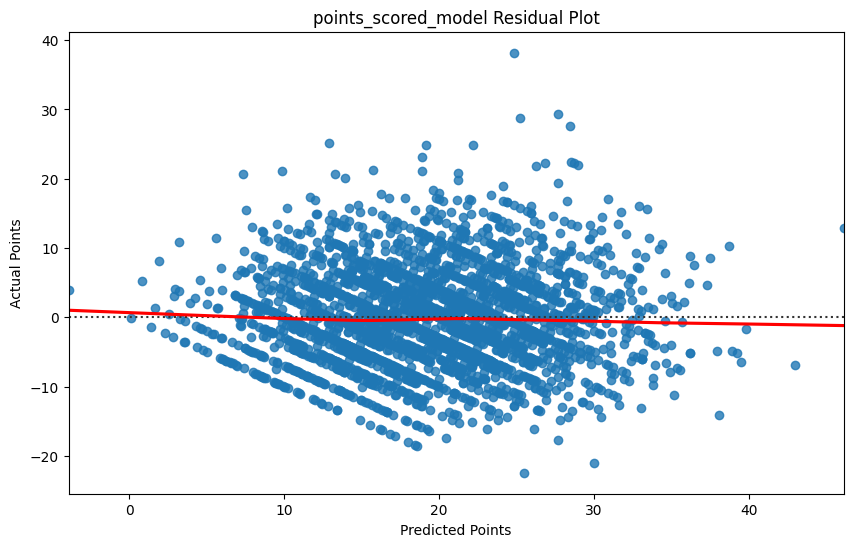

In [ ]:
fit = points_scored_model.fittedvalues
resid = points_scored_model.resid

plt.figure(figsize=(10, 6))
sns.residplot(x=fit, y=resid, lowess=True, line_kws={'color': 'red'})

plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.title('points_scored_model Residual Plot')
plt.show()

##**GLM**
- The Saints, despite having the 2nd biggest sample size, also convert "plus" field position into TD's at the 2nd highest rate. In spite of this, they are only 2-4.

- The Chargers have only converted 1 of 26 (0.04%) "plus" field position opportunities into TD's. This is reflected in their offensive struggles, but their defense has carried them to a 3-2 record so far.

- Passing the ball excessively can stall a drive out moreso than running the ball excessively.
     - While pass plays tend to have a higher ceiling, the downside of passing is you are exposed to more  outcomes that are extremely hurtful to a drives' chance at success: an INT, a sack, a strip-sack fumble, and an incomplete pass. A rushing play only faces the potential consequences of a fumble and a higher chance at a loss of yardage.

In [ ]:
seasons = range(2016, 2024)
pbp = nfl.import_pbp_data(seasons)
pbp2024 = nfl.import_pbp_data([2024])

# Derive a drive-by-drive (dbd) dataframe out of the PBP data
dbd = pbp.groupby(['game_id', 'drive', 'posteam']).agg(
    pass_plays=('play_type', lambda x: (x == 'pass').sum()),
    rush_plays=('play_type', lambda x: (x == 'run').sum()),
    total_plays=('play_type', 'count'),
    total_yards=('yards_gained', 'sum'),
    total_sacks=('sack', 'sum'),
    total_first_downs=('first_down', 'sum'),
    drive_ended_with_score=('drive_ended_with_score', 'max'), # Hold the "drive_ended_with_score" field available in the PBP data
    total_td=('touchdown', 'sum'),
    total_made_field_goals=('field_goal_result', lambda x: (x == 'made').sum())
).reset_index()

# Same thing but for 2024 specific data
dbd2024 = pbp2024.groupby(['game_id', 'drive', 'posteam']).agg(
    pass_plays=('play_type', lambda x: (x == 'pass').sum()),
    rush_plays=('play_type', lambda x: (x == 'run').sum()),
    total_plays=('play_type', 'count'),
    total_yards=('yards_gained', 'sum'),
    total_sacks=('sack', 'sum'),
    total_first_downs=('first_down', 'sum'),
    drive_ended_with_score=('drive_ended_with_score', 'max'),
    total_td=('touchdown', 'sum'),
    total_made_field_goals=('field_goal_result', lambda x: (x == 'made').sum())
).reset_index()

# Add the starting field position field
# Filter the first play of each drive
first_play_of_drive = pbp[pbp['play_id'] == pbp['drive_play_id_started']][['game_id', 'drive', 'posteam', 'yardline_100']]

# Rename
first_play_of_drive.rename(columns={'yardline_100': 'yds_to_endzone'}, inplace=True)

# Merge starting field position into the dbd dataframe
dbd = dbd.merge(first_play_of_drive, on=['game_id', 'drive', 'posteam'], how='left')

# Add 'field_position' field that marks drives that begin at mid field or in opponent's territory as "plus", everything else as "normal"
dbd['field_position'] = np.where(dbd['yds_to_endzone'] <= 50, 'plus', 'normal')

# Same thing but for 2024
first_play_of_drive = pbp2024[pbp2024['play_id'] == pbp2024['drive_play_id_started']][['game_id', 'drive', 'posteam', 'yardline_100']]

first_play_of_drive.rename(columns={'yardline_100': 'yds_to_endzone'}, inplace=True)

dbd2024 = dbd2024.merge(first_play_of_drive, on=['game_id', 'drive', 'posteam'], how='left')

dbd2024['field_position'] = np.where(dbd2024['yds_to_endzone'] <= 50, 'plus', 'normal')

# Filter 2024 dataset to only drives that are "plus" (midfield or closer to EZ)
plus_field_position_drives_2024 = dbd2024[dbd2024['field_position'] == 'plus']

# Group by team, calculate the number of "plus" drives and the number of TD's
team_td_conversion = plus_field_position_drives_2024.groupby('posteam').agg(
    total_plus_drives=('drive', 'count'),
    total_plus_tds=('total_td', 'sum')
).reset_index()

# Calculate TD conversion rate
team_td_conversion['td_conversion_rate'] = team_td_conversion['total_plus_tds'] / team_td_conversion['total_plus_drives']

# Descending order
team_td_conversion = team_td_conversion.sort_values(by='td_conversion_rate', ascending=False)


2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.


<Axes: xlabel='total_plus_drives', ylabel='total_plus_tds'>

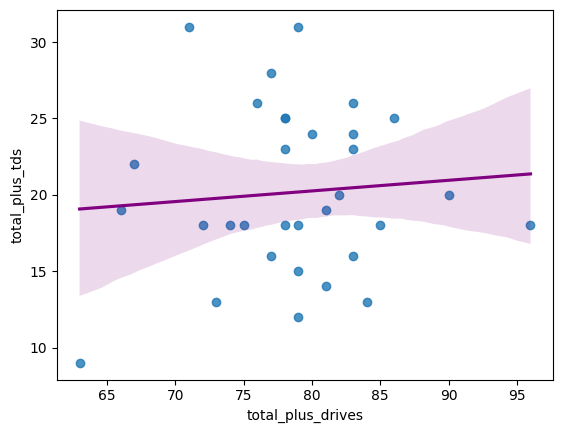

In [ ]:
sns.regplot(
    data = team_td_conversion,
    x = 'total_plus_drives',
    y = 'total_plus_tds',
    line_kws={'color': 'purple'}
)

<Axes: xlabel='yds_to_endzone', ylabel='drive_points_pct'>

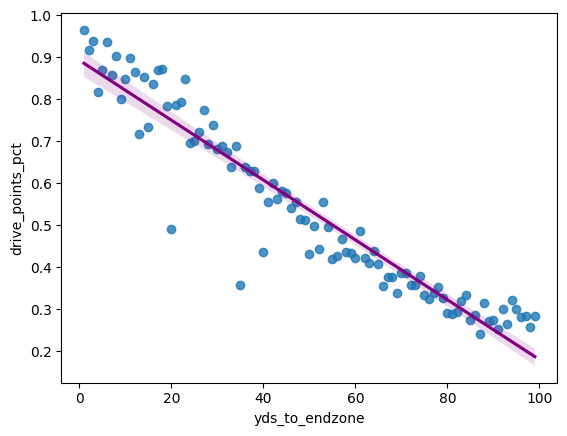

In [ ]:
fp_dpp = dbd.groupby('yds_to_endzone').agg(
    drive_points_pct=('drive_ended_with_score', 'mean')
).reset_index()

sns.regplot(
    data = fp_dpp,
    x = 'yds_to_endzone',
    y = 'drive_points_pct',
    line_kws={'color': 'purple'}
)

In [ ]:
glm = smf.glm(
    formula = 'drive_ended_with_score ~ total_plays',
    data = dbd,
    family = sm.families.Binomial()
).fit()

glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     drive_ended_with_score   No. Observations:                49070
Model:                                GLM   Df Residuals:                    49068
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -26987.
Date:                    Tue, 10 Dec 2024   Deviance:                       53974.
Time:                            02:50:44   Pearson chi2:                 5.09e+04
No. Iterations:                         4   Pseudo R-squ. (CS):             0.2032
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.7726      0.027   -101.347      0.000      -2.826      -2.719
total_plays     0.3014      0.003     91.251      0.000       0.295       0.308
===============================================================================
"""

In [ ]:
glm2 = smf.glm(
    formula = 'drive_ended_with_score ~ pass_plays + '
              'rush_plays + total_yards + total_sacks + '
              'total_first_downs + yds_to_endzone',
    data = dbd,
    family = sm.families.Binomial()
).fit()

glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     drive_ended_with_score   No. Observations:                48873
Model:                                GLM   Df Residuals:                    48866
Model Family:                    Binomial   Df Model:                            6
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -17252.
Date:                    Tue, 10 Dec 2024   Deviance:                       34504.
Time:                            02:50:44   Pearson chi2:                 5.66e+04
No. Iterations:                         6   Pseudo R-squ. (CS):             0.4626
Covariance Type:                nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8663      0.040    -21.792      0.000      -0.944      -0.788
pass_plays           -0.3907      0.009    -41.948      0.000      -0.409      -0.372
rush_plays           -0.2424      0.009    -26.005      0.000      -0.261      -0.224
total_yards           0.0558      0.001     54.715      0.000       0.054       0.058
total_sacks          -0.1493      0.033     -4.480      0.000      -0.215      -0.084
total_first_downs     0.9530      0.021     46.006      0.000       0.912       0.994
yds_to_endzone       -0.0267      0.001    -39.530      0.000      -0.028      -0.025
=====================================================================================
"""

- More rush plays during a drive decrease the likelihood of scoring, but to a lesser extent than pass plays
- Beginning field position doesn't have quite the impact on a driving scoring or not as I thought it would

##**Poisson**

- Third Down Conversion % is the strongest factor I evaluated in estimating the number of TD's a team will score in a game
- Previous TD Rate is also strong
- The game's pre-game Total Line is not as strong of a factor as I would have thought
  - A team's Total Line is surely a better indicator

In [ ]:
seasons = range(2017, 2024)
pbp = nfl.import_pbp_data(seasons)

# Grabbing the columns I want to look at/use for EDA and Modeling
cols = ['game_id', 'posteam', 'defteam', 'passing_yards', 'rushing_yards', 'play_type',
           'third_down_converted', 'third_down_failed', 'penalty_yards',
           'interception', 'fumble_lost', 'touchdown', 'posteam_score', 'defteam_score',
           'total_home_score', 'total_away_score', 'total_line', 'season', 'week']

pbp = pbp[cols]

# Add turnovers field
pbp['turnovers'] = pbp['interception'] + pbp['fumble_lost']

# Group by and aggregate for game by game dataframe
gbg = pbp.groupby(['game_id', 'posteam', 'season', 'week']).agg(
    passing_yards=('passing_yards', 'sum'),
    rushing_yards=('rushing_yards', 'sum'),
    turnovers=('turnovers', 'sum'),
    penalties=('penalty_yards', 'sum'),
    third_down_converted=('third_down_converted', 'sum'),
    third_down_failed=('third_down_failed', 'sum'),
    touchdowns=('touchdown', 'sum'),
    points_scored=('posteam_score', 'max'),
    total_line=('total_line', 'mean'),

).reset_index()

# Calculate third down conversion rate
gbg['third_down_conversion_rate'] = gbg['third_down_converted'] / (gbg['third_down_converted'] + gbg['third_down_failed'])

2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


<ipython-input-61-e886f2856949>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp['turnovers'] = pbp['interception'] + pbp['fumble_lost']


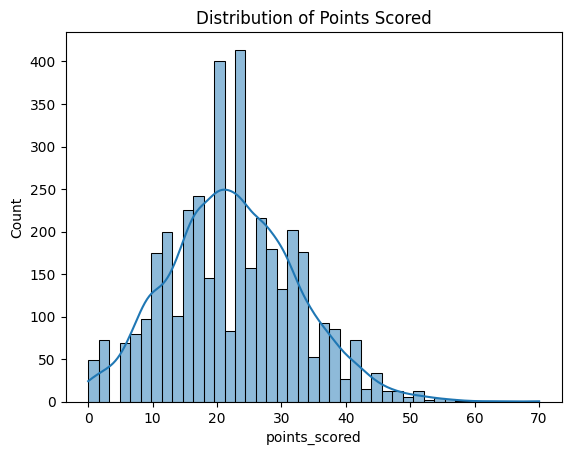

In [ ]:
sns.histplot(gbg['points_scored'], kde=True)
plt.title('Distribution of Points Scored')
plt.show()

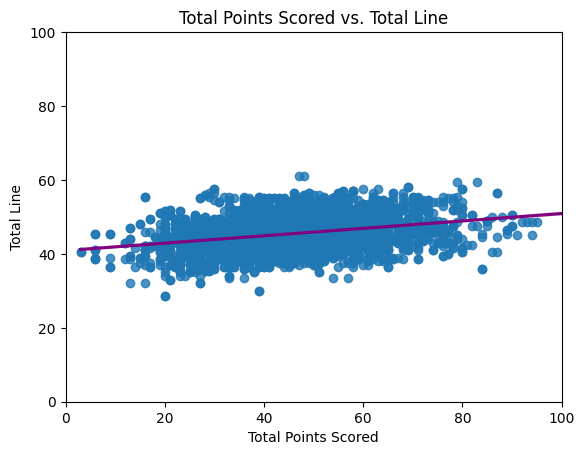

In [ ]:
# Want to compare the Total Line vs. The Total Result
# Aggregate to get the final scores for both teams in each game
scores = pbp.groupby(['game_id', 'posteam']).agg(
    posteam_score=('posteam_score', 'max'),
    defteam_score=('defteam_score', 'max'),
    total_line=('total_line', 'mean')
).reset_index()

# Add total points scored column
scores['total_points_scored'] = scores['posteam_score'] + scores['defteam_score']

# Create Reg plot
sns.regplot(
    data=scores,
    x='total_points_scored',
    y='total_line',
    line_kws={'color': 'purple'}
)

# Ensures both axis' match
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(range(0, 101, 20))
plt.yticks(range(0, 101, 20))

plt.title('Total Points Scored vs. Total Line')
plt.xlabel('Total Points Scored')
plt.ylabel('Total Line')

plt.show()

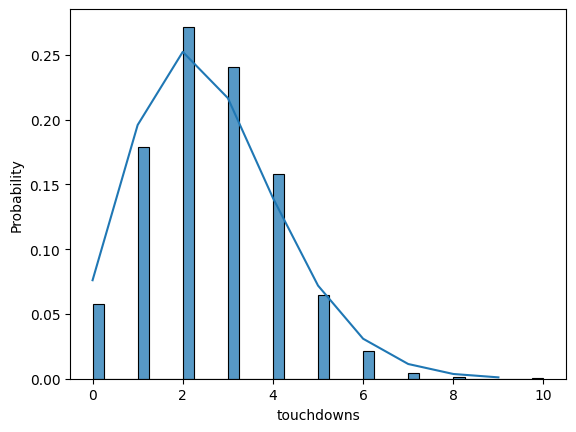

In [ ]:
# calculate mean for Poisson
touchdowns_mean = gbg.touchdowns.mean()

touchdowns_mean

# list comprehension
# PMF for Poisson
plot_pos_py = pd.DataFrame(
    {
        'x': range(0,10),
        'expected': [poisson.pmf(x, touchdowns_mean) for x in range(0,10)]
    }
)

# hist plot - seaborn
sns.histplot(
    gbg['touchdowns'],
    stat = 'probability'
)

plt.plot(plot_pos_py.x, plot_pos_py.expected)
plt.show()

In [ ]:
# Initialize an empty DataFrame to store results
x_td = pd.DataFrame()

# Loop over seasons and weeks (2017-2023)
for season_idx in range(2017, 2023 + 1):
    for week_idx in range(1, 22 + 1):  # 22 is the maximum possible number of weeks in a season including playoffs
        # Filter data to get current and past season data up to the current week
        week_calc_td = (
            pbp.query(
                '(season == ' + str(season_idx - 1) + ') | ' +
                '(season == ' + str(season_idx) + ' & week <= ' + str(week_idx) + ')'
            )
            .groupby(['posteam'])  # Group by team (posteam)
            .agg(
                touchdowns=('touchdown', 'sum'),  # Sum total touchdowns
                n_games=('game_id', 'nunique')  # Count unique game IDs for total games played
            )
        )

        # Calculate td_rate: total touchdowns divided by the number of games
        week_calc_td['td_rate'] = week_calc_td['touchdowns'] / week_calc_td['n_games']

        # Reset index to prepare the DataFrame
        week_calc_td.reset_index(inplace=True)

        # Add season and week columns to the DataFrame
        week_calc_td['season'] = season_idx
        week_calc_td['week'] = week_idx

        # Concatenate with the main DataFrame
        x_td = pd.concat([x_td, week_calc_td])

# Rename columns in x_td to avoid duplicates
x_td.rename(columns={
    'touchdowns': 'tds',
    'n_games': 'total_games',
    'td_rate': 'td_rate'
}, inplace=True)

# Merge with gbg
model_df = pd.merge(gbg, x_td, on=['season', 'week', 'posteam'], how='left')

# fit td_model poisson
td_model = smf.glm(
    formula='touchdowns ~ passing_yards + rushing_yards + turnovers + penalties + third_down_conversion_rate + total_line + td_rate',
    data=model_df,
    family=sm.families.Poisson()
).fit()

# predict with model - expected Team TD's
model_df['exp_tds'] = td_model.predict()

print(td_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             touchdowns   No. Observations:                 3848
Model:                            GLM   Df Residuals:                     3840
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6146.4
Date:                Tue, 10 Dec 2024   Deviance:                       2161.7
Time:                        02:51:29   Pearson chi2:                 1.88e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2933
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

##**Web Scraping**
I was interested to look at a wide-range of different aspects of the data set that the Pro Football Reference Draft Pages provide us. Since we looked at DrAV in our class exampl of web scraping, I decided to hone in on Pro Bowl appearances as my main target for player value.

Some of my takeaways from my EDA and my Modeling:

- Alabama has unquestionably been the best school in producing high-end draft picks, but also players who have productive careers too
- 1st Round picks overwhelmingly produce the most pro bowl appearances, as common theory would also suggest
- Not a huge disparity in Pro Bowl's in the 4th round - 6th round range
- Despite being neck-and-neck with the Chiefs in Pro Bowl Appearances drafted during the 2010's decade, the Cowboys have parlayed that success drafting to very little playoff success, as opposed to the Chiefs who have used their strong drafting to 3 Super Bowls in the last 4 years
- While my Linear Regression model wasn't bad, the added complexities of the Random Forest Model allowed for a better model and better accuracy

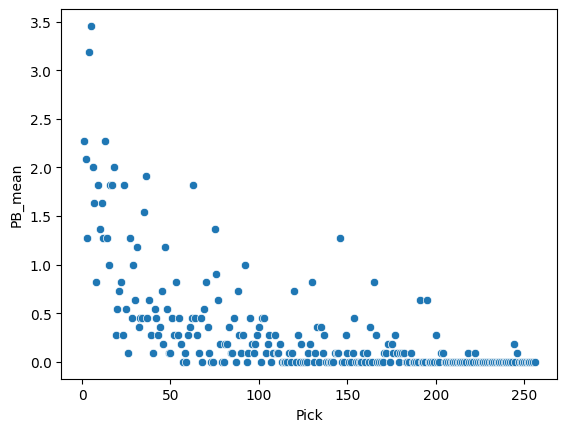

In [ ]:
# Loop through draft years: 2010-2020
draft_py = pd.DataFrame() # Empty df

# for loop -> go through the years
for i in range(2010, 2020 + 1):
  url = 'https://www.pro-football-reference.com/years/' + str(i) + '/draft.htm'
  # pass in url and read in that year's data
  web_data = pd.read_html(url, header = 1)[0]
  # add season col to dataframe
  web_data['season'] = i
  # Add query to filter out 'Tm' in table
  web_data = web_data.query('Tm != "Tm"')
  # Now, we concat to empty df
  draft_py = pd.concat([draft_py, web_data])

  # reset index after loop
  draft_py.reset_index(drop = True, inplace = True)

  # fill in missing values
draft_py.loc[draft_py['DrAV'].isnull(), 'DrAV'] = 0
draft_py.loc[draft_py['AP1'].isnull(), 'AP1'] = 0
draft_py.loc[draft_py['PB'].isnull(), 'PB'] = 0
draft_py.loc[draft_py['St'].isnull(), 'St'] = 0

# fix some data in  position column
draft_py['Pos'] = draft_py['Pos'].replace('T', 'OT')
draft_py['Pos'] = draft_py['Pos'].replace('NT', 'DT')
draft_py['Pos'] = draft_py['Pos'].replace('DL', 'DT')

# Rename teams
conditions = [
    (draft_py.Tm == 'SDG'),
    (draft_py.Tm == 'OAK'),
    (draft_py.Tm == 'STL')
]

# Choices
choices = [
    'LAC', 'LVR', 'LAR'
]

# np.select(conditions, choices)
draft_py['Tm'] = np.select(conditions, choices, default = draft_py.Tm)

draft_py = draft_py.astype(
    {
        'Pick': int,
        'Rnd': int,
        'AP1': float,
        'PB': float,
        'St': float,
        'wAV': float,
        'DrAV': float
    }
)

# Subsetting for cleaned data frame
draft_data = draft_py[['Player', 'Pos', 'College/Univ', 'Rnd', 'Pick', 'Tm']]

draft_py_use = draft_py[['season', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'AP1', 'PB', 'St', 'wAV', 'DrAV', 'College/Univ']]

# Pro Bowls for each pick position
draft_py_pb = draft_py_use.groupby(
    ['Pick']).agg({'PB':['mean']})

# fix column names
draft_py_pb.columns = list(
    map("_".join, draft_py_pb.columns)
)
draft_py_pb.reset_index(inplace = True)


# create our rolling average
draft_py_pb['roll_pb'] = (
    draft_py_pb['PB_mean'].rolling(
        window = 13, min_periods = 1, center = True
    ).mean()
)

# create scatterplot
sns.scatterplot(
    draft_py_pb,
    x = 'Pick',
    y = 'PB_mean'
)

plt.show();

**Linear Regression Model**

In [ ]:
# add regression
draft_py_pb['roll_PB_log'] = np.log(draft_py_pb['roll_pb'] +1)

# regression line
PB_pick_fit_py = smf.ols(
    formula = 'roll_PB_log ~ Pick',
    data = draft_py_pb
).fit()

PB_pick_fit_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            roll_PB_log   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     629.8
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           9.98e-71
Time:                        02:51:32   Log-Likelihood:                 135.23
No. Observations:                 256   AIC:                            -266.5
Df Residuals:                     254   BIC:                            -259.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6315      0.018     35.164      0.000       0.596       0.667
Pick          -0.0030      0.000    -25.096      0.000      -0.003      -0.003
==============================================================================
Omnibus:                       80.066   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.452
Skew:                           1.486   Prob(JB):                     1.97e-41
Kurtosis:                       5.957   Cond. No.                         297.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean Absolute Error (MAE): 0.09
Mean Squared Error (MSE): 0.02
R-squared: 0.77


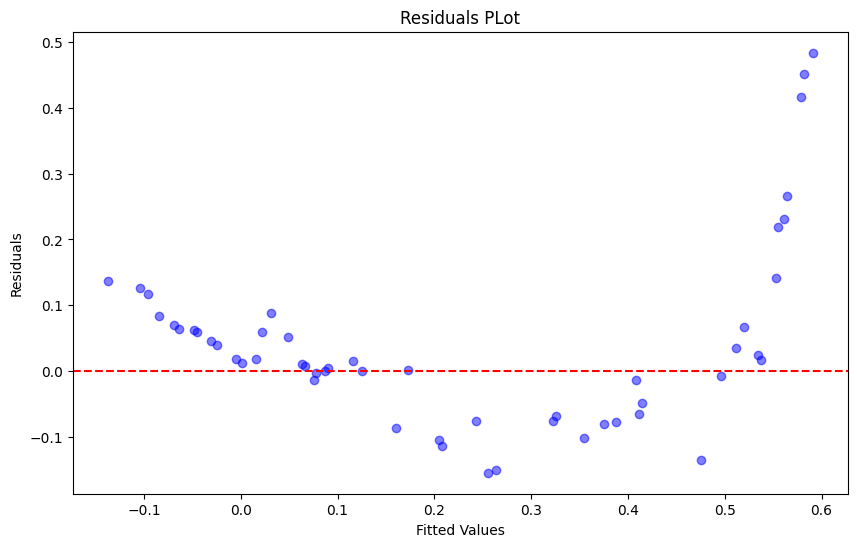

In [ ]:
features = draft_py_pb[['Pick']]
target = draft_py_pb['roll_PB_log']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model performance
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Look at residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals PLot")
plt.show()

- Curve & almost a slight U-shaped pattern

##**PCA & Clustering**

- A true "run-dominant" offense no longer really exists in the modern NFL - even the most run-heavy teams still rely on a nearly balanced dose of passing

- A high number of instances fall under cluster 5, which is a balanced offensive in pass attempts vs. rush attempts

2023 done.
Downcasting floats.


<Axes: xlabel='total_pass_attempts', ylabel='total_rush_attempts'>

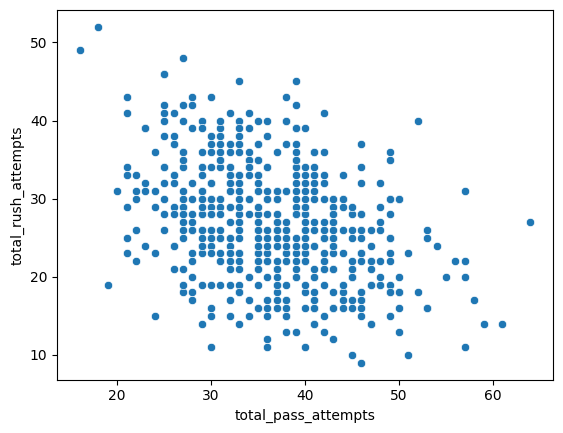

In [ ]:
pbp = nfl.import_pbp_data([2023])

# filtering for columns that could be relevant for my research
offense_columns = [
    'game_id',
    'posteam',
    'defteam',
    'yards_gained',
    'pass_attempt',
    'rush_attempt',
    'touchdown',
    'interception',
    'sack'
]

# apply the filter to my play by play df
filtered_pbp = pbp[offense_columns]

# Drop rows with missing values to ensure there are no NaN's
filtered_pbp = filtered_pbp.dropna()

# Aggregate the data by team and by game
gbg_data = filtered_pbp.groupby(['posteam', 'game_id']).agg(
    total_yards=('yards_gained', 'sum'),
    td_scored=('touchdown', 'sum'),
    total_pass_attempts=('pass_attempt', 'sum'),
    total_rush_attempts=('rush_attempt', 'sum'),
    total_int=('interception', 'sum'),
    total_sacks=('sack', 'sum')
)

gbg_data = gbg_data.reset_index()

sns.scatterplot(data=gbg_data, x='total_pass_attempts', y='total_rush_attempts')

In [ ]:
# use KNNImputer to impute missing values

# create a list of columns to impute
cols_impute = ['total_yards', 'td_scored', 'total_pass_attempts', 'total_rush_attempts',
               'total_int', 'total_sacks']

# create a KNN combine object
# axis = 1 refers to the column axis
gbg_knn_py = gbg_data.drop(cols_impute, axis = 1)

# create an instance of the KNN imputer class
imputer = KNNImputer(n_neighbors = 9)

# now, fit_transform this object on our data
# most models have 3 modes: fit, transform, fit_transform
# fit - train a model on the data passed to it
# transform - transform the data but it must be fit first
# fit_transform - fit on the data, then transform it
knn_out_py = imputer.fit_transform(gbg_data[cols_impute])

# convert back to a df
knn_out_py = pd.DataFrame(knn_out_py)

# change column names from imputer to match og object
knn_out_py.columns = cols_impute

#combine this data back with original
# axes typically 0 or 1
# o refers to the rows; 1 to the columns
gbg_knn_py = pd.concat(
    [gbg_knn_py, knn_out_py], axis = 1
)

pca = PCA(svd_solver = 'full')

# KNN is sensitive to scale
# subtract mean & divide by std for select cols
scaled_gbg_knn_py = (
    gbg_knn_py[cols_impute] - gbg_knn_py[cols_impute].mean()
) / gbg_knn_py[cols_impute].std()

# fit pca on scaled data and transform it
pca_fit_py = pca.fit_transform(scaled_gbg_knn_py)

# showcase rotation (PCs) of data
rotation = pd.DataFrame(pca.components_, index = cols_impute)

# convert to %
pca_percent_py = pca.explained_variance_ratio_.round(4) * 100
print(pca_percent_py)

[38.04     22.99     13.950001 12.179999  9.34      3.5     ]


38.04 + 22.99 + 13.95001 + 12.179999 = 87.16
- Use first 4 PC's

<Axes: xlabel='PC1', ylabel='PC2'>

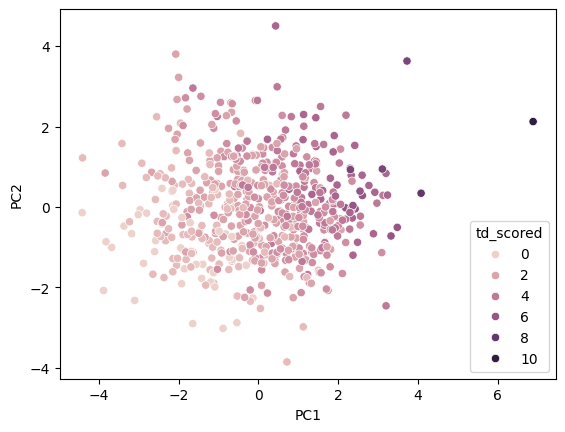

In [ ]:
# create a df for PCA
pca_fit_py = pd.DataFrame(pca_fit_py)

# add column names
pca_fit_py.columns = ["PC" + str(i + 1) for i in range(len(pca_fit_py.columns))]

gbg_knn_py = pd.concat([gbg_knn_py, pca_fit_py], axis = 1)

# Scatterplot of PC1 and PC2 with TD's Scored as the hue
sns.scatterplot(data = gbg_knn_py, x = 'PC1', y = 'PC2', hue = 'td_scored')

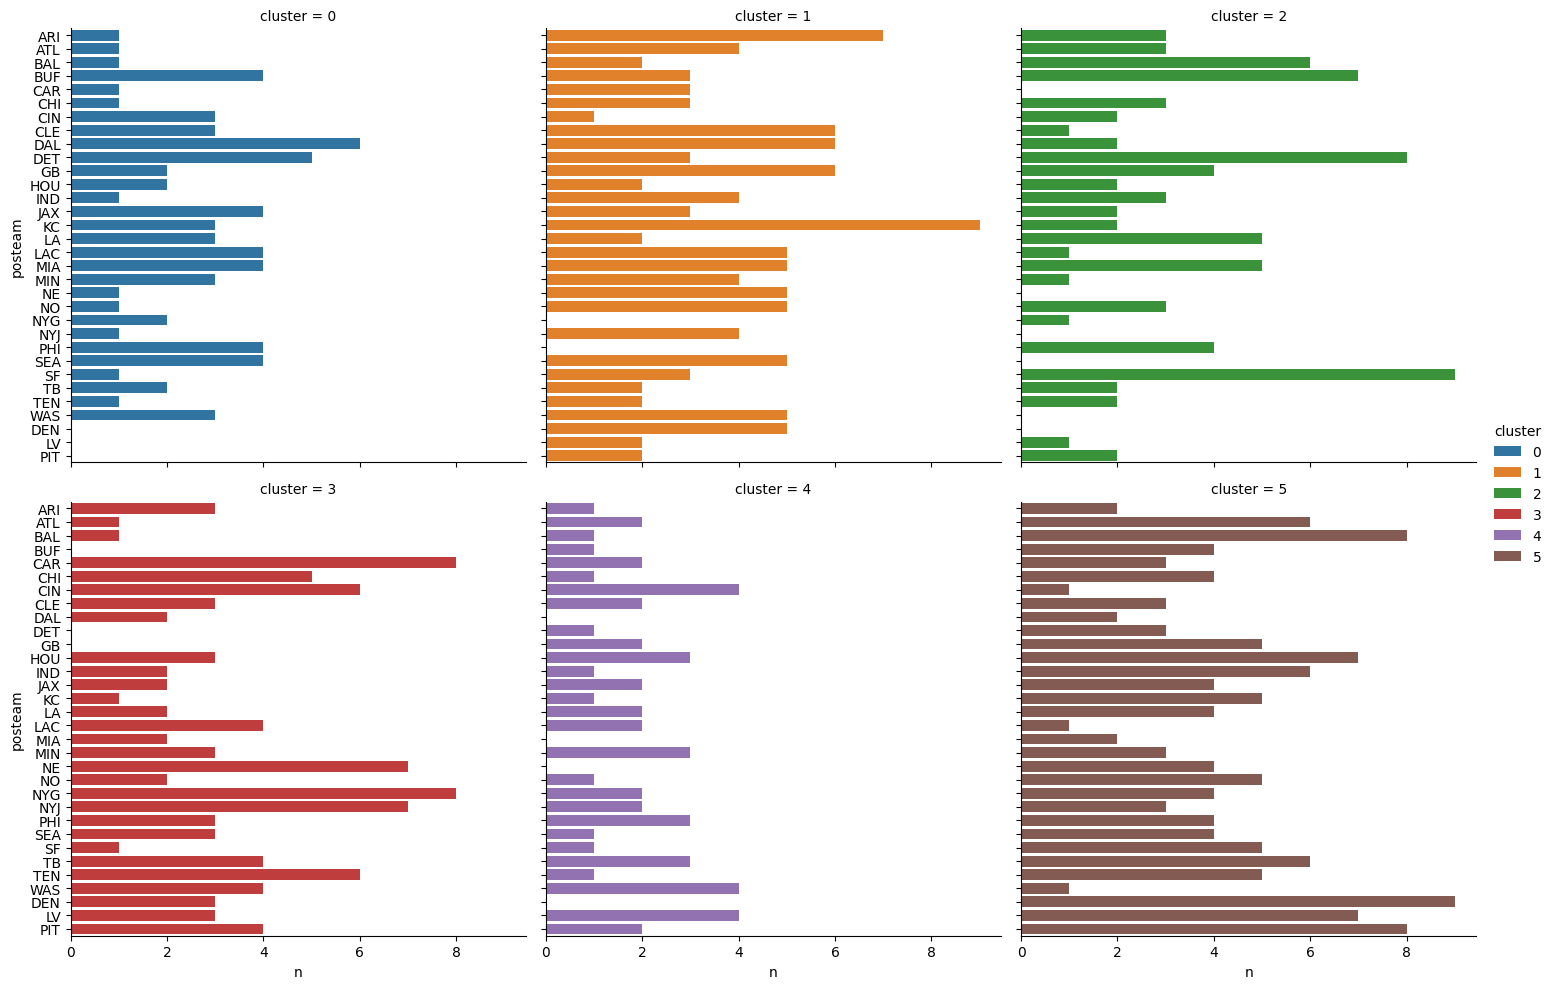

In [ ]:
# to keep roughly 90% variance, keep the first 4 PC's
pca = PCA(svd_solver='full', n_components=4)

pca_fit_py = pca.fit_transform(scaled_gbg_knn_py)

# clustering
k_means_fit_py = kmeans(
    gbg_knn_py[["PC1", "PC2"]], 6, seed = 1234
)

# add cluster label to data
gbg_knn_py['cluster'] = (
    vq(gbg_knn_py[['PC1', 'PC2']], k_means_fit_py[0])[0]
    )

# group by cluster & team
gbg_knn_py_cluster = (
    gbg_knn_py.groupby(['cluster', 'posteam']).agg(
        {'total_pass_attempts': ['count', 'mean'], 'total_rush_attempts':['count', 'mean']}
    )
    )

# fix column names
gbg_knn_py_cluster.columns = list(
    map(
        "_".join, gbg_knn_py_cluster.columns
    )
)

# reset index
gbg_knn_py_cluster.reset_index(inplace = True)

# rename columns
gbg_knn_py_cluster.rename(
    columns = {
        'total_pass_attempts_count' : 'n',
        'total_pass_attempts_mean' : 'Pass Attempts',
        'total_rush_attempts_mean' : 'Rush Attempts',
    }, inplace = True
)

# type cast cluster col
gbg_knn_py_cluster.cluster = gbg_knn_py_cluster.cluster.astype(str)

# group by cluster and not position
gbg_knn_py_cluster.groupby('cluster').agg(
    {
        'Pass Attempts': ['mean'],
        'Rush Attempts': ['mean']
    }
)

# catplot
sns.catplot(
    gbg_knn_py_cluster,
    x = 'n', # number of instances
    y = 'posteam', # position played
    col = 'cluster', # col by cluster
    hue = 'cluster', # color by cluster
    col_wrap = 3, # facet wrap - 3 cols
    kind = 'bar' # horizontal chart
)

**Cluster 0**: Pass-heavy offense, above-average total plays

**Cluster 1**: Pass-heavy offense, average total plays

**Cluster 2**: Balanced offense, above-average total plays

**Cluster 3**: Pass-heavy offense, below-average total plays

**Cluster 4**: Extremely pass-heavy offense, average total plays

**Cluster 5**: Balanced offense, average total plays